In [1]:
%matplotlib notebook
import control as c
import ipywidgets as w
import numpy as np

from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.transforms as transforms
import matplotlib.animation as animation

display(HTML('<script> $(document).ready(function() { $("div.input").hide(); }); </script>'))

## Szabályozó tervezés egy gömb és gerenda rendszerhez

A példa során egy gömb és gerenda mechanizmushoz kell szabályozót tervezni. A szerkezet egy gerendából, és egy azon egyensúlyozott gömbből áll. A gerenda egy mozgató mechanikával van ellátva, ami vagy közvetlenül, vagy egy áttétel segítségével képes az orientációját változtatni. A cél a gömb pozíciójának szabályozása a gerendán.
<br><br>
<table><tbody><tr>
<td><center><img src="Images/bbdir.png" width="65%" /></center></td>
<td><center><img src="Images/bbmech.png" width="65%" /></center></td>
</tr>
<tr>
<td><center>Közvetlen hajtás</center></td><td><center>Hajtás áttétellel</center></td>
</tr></tbody></table>
<br>

Bár a rendszer nem-lineáris, azaz a klasszikus irányítástechnika területén kívül esik, néhány egyszerűsítést követően linearizálható és tervezhető hozzá szabályozás az állandósult állapot közelében. Fontos viszont, hogy nagyobb mozgások esetében nem teljesülnek az egyszerűsítések, a szimuláció a valóságtól eltérően működik.

A linearizált mozgásegyenletek: 
<br>
$$\left(\frac{J}{r^2}+m\right)\cdot\ddot x=-m\cdot g\cdot\alpha\qquad\left(\frac{J}{r^2}+m\right)\cdot\ddot x=-\frac{m\cdot g\cdot d}{L}\cdot\varphi$$
<br>
Ahol:
<br>
$$J=\frac{2}{5}m\cdot r^2$$
<br>
Laplace transzformációt követően a rendszer átviteli függvénye az alábbi:
<br>
$$G_{dir}(s)=-\frac{m\cdot g}{\left(\frac{J}{r^2}+m\right)\cdot s^2}\qquad G_{mech}(s)=-\frac{m\cdot g\cdot d}{L\cdot\left(\frac{J}{r^2}+m\right)\cdot s^2}$$
<br>
A feladata, hogy válasszon egy szabályozót és hangolja be megfelelő minőségben!

<b>Válasszon egy rendszertípust!</b><br>
A feladathoz használja a rögzített modelltípusokat a *Modell 1* - *Modell 6* gombokkal. A *Demó* opciót választva a rendszer egy minta esetet mutat be, aminek a szabályozója előre be lett állítva és nem módosítható.
A két kialakítás matematikailag ekvivalens az egyszerűsítések miatt.

In [2]:
# Model selector buttons
typeSelect = w.ToggleButtons(
    options=[('Közvetlen hajtás', 0), ('Hajtás áttétellel', 1),],
    description='Kialakítás: ')

display(typeSelect)

ToggleButtons(description='Kialakítás: ', options=(('Közvetlen hajtás', 0), ('Hajtás áttétellel', 1)), value=0…

<IPython.core.display.Javascript object>


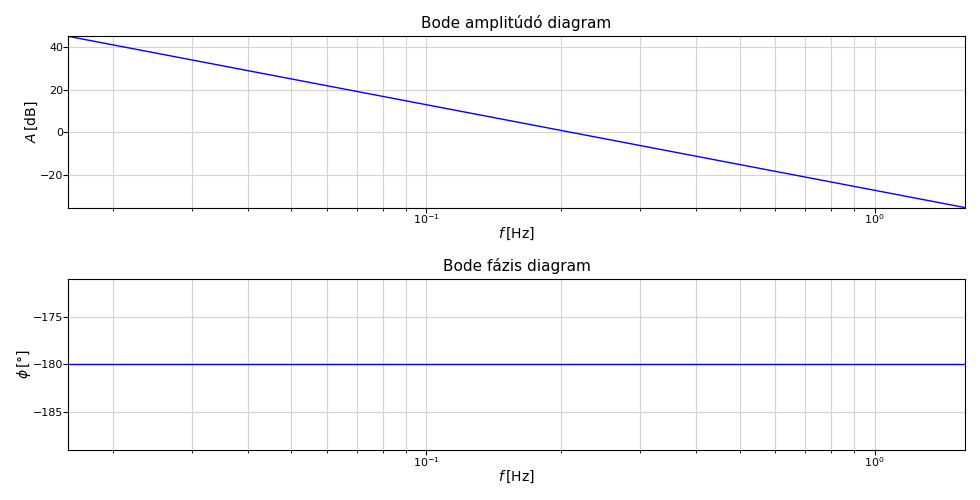

ToggleButtons(description='Rendszer: ', index=6, layout=Layout(width='60%'), options=(('Modell 1', 0), ('Model…

Output()

Output()

In [3]:
# System parameters

g = 9.81   # m/s^2 - gravitational acceleration

# Figure definition

fig1, ((f1_ax1), (f1_ax2)) = plt.subplots(2, 1)
fig1.set_size_inches((9.8, 5))
fig1.set_tight_layout(True)

f1_line1, = f1_ax1.plot([], [])
f1_line2, = f1_ax2.plot([], [])  

f1_ax1.grid(which='both', axis='both', color='lightgray')
f1_ax2.grid(which='both', axis='both', color='lightgray')

f1_ax1.autoscale(enable=True, axis='both', tight=True)
f1_ax2.autoscale(enable=True, axis='both', tight=True)

f1_ax1.set_title('Bode amplitúdó diagram', fontsize=11)
f1_ax1.set_xscale('log')
f1_ax1.set_xlabel(r'$f\/$[Hz]', labelpad=0, fontsize=10)
f1_ax1.set_ylabel(r'$A\/$[dB]', labelpad=0, fontsize=10)
f1_ax1.tick_params(axis='both', which='both', pad=0, labelsize=8)

f1_ax2.set_title('Bode fázis diagram', fontsize=11)
f1_ax2.set_xscale('log')
f1_ax2.set_xlabel(r'$f\/$[Hz]', labelpad=0, fontsize=10)
f1_ax2.set_ylabel(r'$\phi\/$[°]', labelpad=0, fontsize=10)
f1_ax2.tick_params(axis='both', which='both', pad=0, labelsize=8)

def build_base_model(m, r, d, L, type_select):
   
    J=2/5*m*r*r
    if type_select:
        W_sys = c.tf([m*g*d], [L*(J/(r*r)+m), 0, 0])
    else:
        W_sys = c.tf([m*g], [J/(r*r)+m, 0, 0])
    
    print('Átviteli függvény:')
    print(W_sys)
    
    # System analysis
    
    poles = c.pole(W_sys)     # Poles
    
    print('Pólusok:\n')
    print(poles)
    
    global f1_line1, f1_line2
    
    f1_ax1.lines.remove(f1_line1)
    f1_ax2.lines.remove(f1_line2)
    
    mag, phase, omega = c.bode_plot(W_sys, Plot=False)   # Bode-plot
    
    f1_line1, = f1_ax1.plot(omega/2/np.pi, 20*np.log10(mag), lw=1, color='blue')
    f1_line2, = f1_ax2.plot(omega/2/np.pi, phase*180/np.pi, lw=1, color='blue')   
    
    f1_ax1.relim()
    f1_ax2.relim()
    f1_ax1.autoscale_view()
    f1_ax2.autoscale_view()
    
def update_sliders(index, model):
    global m_slider, r_slider, d_slider, L_slider

    mval = [0.05, 0.05, 0.1, 0.1, 0.5, 0.5, 0.25]
    rval = [0.01, 0.05, 0.05, 0.1, 0.1, 0.15, 0.075]
    dval = [0.025, 0.01, 0.05, 0.2, 0.2, 0.4, 0.2]
    Lval = [0.1, 0.1, 0.5, 1, 2, 2, 1]

    m_slider.value = mval[index]
    r_slider.value = rval[index]
    d_slider.value = dval[index]
    L_slider.value = Lval[index]
    
    if index == -1:
        m_slider.disabled = True;
        r_slider.disabled = True;
        d_slider.disabled = True;
        L_slider.disabled = True;
    else:
        m_slider.disabled = False;
        r_slider.disabled = False;
        
        if model == 0:
            d_slider.disabled = False;
            L_slider.disabled = False;
        else:
            d_slider.disabled = True;
            L_slider.disabled = True; 
    
# GUI widgets
    
typeSelect2 = w.ToggleButtons(
    options=[('Modell 1', 0), ('Modell 2', 1), ('Modell 3', 2), ('Modell 4', 3), ('Modell 5', 4), ('Modell 6', 5),
             ('Demó', -1)],
    value=-1, description='Rendszer: ', layout=w.Layout(width='60%'))

m_slider = w.FloatLogSlider(value=1, base=10, min=-2, max=1, description='m [kg] :', continuous_update=False,
                            layout=w.Layout(width='auto', flex='5 5 auto'))
r_slider = w.FloatLogSlider(value=0.1, base=10, min=-3, max=0, description='r [m] :', continuous_update=False,
                            layout=w.Layout(width='auto', flex='5 5 auto'))

d_slider = w.FloatLogSlider(value=0.1, base=10, min=-3, max=0, description='d [m] :', continuous_update=False,
                            layout=w.Layout(width='auto', flex='5 5 auto'))
L_slider = w.FloatLogSlider(value=0, base=10, min=-1, max=2, description='L [m] :', continuous_update=False,
                            layout=w.Layout(width='auto', flex='5 5 auto'))

input_data = w.interactive_output(build_base_model, {'m':m_slider, 'r':r_slider, 'd':d_slider, 'L':L_slider,
                                                     'type_select':typeSelect})  

input_data2 = w.interactive_output(update_sliders, {'index':typeSelect2, 'model':typeSelect})

display(typeSelect2, input_data2)

display(w.HBox([w.VBox([m_slider, r_slider], layout=w.Layout(width='45%')),
                w.VBox([d_slider, L_slider], layout=w.Layout(width='45%'))]), input_data)


A komoly egyszerűsítéseknek köszönhetően a rendszer egy kettős integrátorra redukálódik.<br>
<br>
<b>Válasszon egy megfelelő szabályozó konfigurációt! Melyik illik a legjobban a rendszerhez? Miért?<br>
Állítsa be úgy a szabályozót, hogy a beállási idő a lehető leggyorsabb legyen, legfeljebb 25% túllövéssel!</b>

Szabadon ki-be kapcsolhatja az I és D tagokat, valamint ha D aktív, alkalmazhat egy egytárolós szűrőt is, ami a deriváló tag időállandójának függvényében adható meg.

<IPython.core.display.Javascript object>


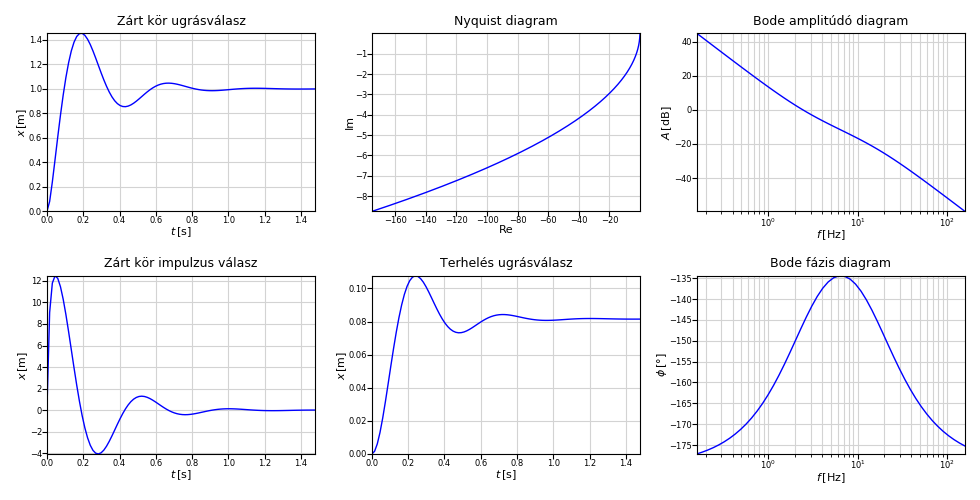

Output()

In [4]:
# PID ball balancer

fig2, ((f2_ax1, f2_ax2, f2_ax3), (f2_ax4, f2_ax5, f2_ax6)) = plt.subplots(2, 3)
fig2.set_size_inches((9.8, 5))
fig2.set_tight_layout(True)

f2_line1, = f2_ax1.plot([], [])
f2_line2, = f2_ax2.plot([], []) 
f2_line3, = f2_ax3.plot([], [])
f2_line4, = f2_ax4.plot([], [])  
f2_line5, = f2_ax5.plot([], [])
f2_line6, = f2_ax6.plot([], [])

f2_ax1.grid(which='both', axis='both', color='lightgray')
f2_ax2.grid(which='both', axis='both', color='lightgray')
f2_ax3.grid(which='both', axis='both', color='lightgray')
f2_ax4.grid(which='both', axis='both', color='lightgray')
f2_ax5.grid(which='both', axis='both', color='lightgray')
f2_ax6.grid(which='both', axis='both', color='lightgray')

f2_ax1.autoscale(enable=True, axis='both', tight=True)
f2_ax2.autoscale(enable=True, axis='both', tight=True)
f2_ax3.autoscale(enable=True, axis='both', tight=True)
f2_ax4.autoscale(enable=True, axis='both', tight=True)
f2_ax5.autoscale(enable=True, axis='both', tight=True)
f2_ax6.autoscale(enable=True, axis='both', tight=True)


f2_ax1.set_title('Zárt kör ugrásválasz', fontsize=9)
f2_ax1.set_xlabel(r'$t\/$[s]', labelpad=0, fontsize=8)
f2_ax1.set_ylabel(r'$x\/$[m]', labelpad=0, fontsize=8)
f2_ax1.tick_params(axis='both', which='both', pad=0, labelsize=6)

f2_ax2.set_title('Nyquist diagram', fontsize=9)
f2_ax2.set_xlabel(r'Re', labelpad=0, fontsize=8)
f2_ax2.set_ylabel(r'Im', labelpad=0, fontsize=8)
f2_ax2.tick_params(axis='both', which='both', pad=0, labelsize=6)

f2_ax3.set_title('Bode amplitúdó diagram', fontsize=9)
f2_ax3.set_xscale('log')
f2_ax3.set_xlabel(r'$f\/$[Hz]', labelpad=0, fontsize=8)
f2_ax3.set_ylabel(r'$A\/$[dB]', labelpad=0, fontsize=8)
f2_ax3.tick_params(axis='both', which='both', pad=0, labelsize=6)

f2_ax4.set_title('Zárt kör impulzus válasz', fontsize=9)
f2_ax4.set_xlabel(r'$t\/$[s]', labelpad=0, fontsize=8)
f2_ax4.set_ylabel(r'$x\/$[m]', labelpad=0, fontsize=8)
f2_ax4.tick_params(axis='both', which='both', pad=0, labelsize=6)

f2_ax5.set_title('Terhelés ugrásválasz', fontsize=9)
f2_ax5.set_xlabel(r'$t\/$[s]', labelpad=0, fontsize=8)
f2_ax5.set_ylabel(r'$x\/$[m]', labelpad=0, fontsize=8)
f2_ax5.tick_params(axis='both', which='both', pad=0, labelsize=6)

f2_ax6.set_title('Bode fázis diagram', fontsize=9)
f2_ax6.set_xscale('log')
f2_ax6.set_xlabel(r'$f\/$[Hz]', labelpad=0, fontsize=8)
f2_ax6.set_ylabel(r'$\phi\/$[°]', labelpad=0, fontsize=8)
f2_ax6.tick_params(axis='both', which='both', pad=0, labelsize=6)

def position_control(Kp, Ti, Td, Fd, Ti0, Td0, m, r, d, L, type_select):
    
    J=2/5*m*r*r
    if type_select:
        W_sys = c.tf([m*g*d], [L*(J/(r*r)+m), 0, 0])
    else:
        W_sys = c.tf([m*g], [J/(r*r)+m, 0, 0])
    
    # PID Controller
    
    P = Kp             # Proportional term
    I = Kp / Ti        # Integral term
    D = Kp * Td        # Derivative term
    Td_f = Td / Fd     # Derivative term filter
    
    W_PID = c.parallel(c.tf([P], [1]),
                       c.tf([I * Ti0], [1 * Ti0, 1 * (not Ti0)]),
                       c.tf([D * Td0, 0], [Td_f * Td0, 1]))  # PID controller in time constant format
    
    W_open = c.series(W_PID, W_sys)         # Open loop 
    W_closed = c.feedback(W_open, 1, -1)    # Closed loop with negative feedback
    
    if type_select:   # Disturbance transfer
        W_load = c.feedback (c.tf([1], [J/r/r+m, 0, 0]), c.series(c.tf([m*g*d], [L]), W_PID), -1)  
    else:
        W_load = c.feedback (c.tf([1], [J/r/r+m, 0, 0]), c.series(c.tf([m*g], [1]), W_PID), -1)
                        
    # Display
    
    global f2_line1, f2_line2, f2_line3, f2_line4, f2_line5, f2_line6
    
    f2_ax1.lines.remove(f2_line1)
    f2_ax2.lines.remove(f2_line2)
    f2_ax3.lines.remove(f2_line3)
    f2_ax4.lines.remove(f2_line4)
    f2_ax5.lines.remove(f2_line5)
    f2_ax6.lines.remove(f2_line6)
    
    tout, yout = c.step_response(W_closed)
    f2_line1, = f2_ax1.plot(tout, yout, lw=1, color='blue')
    
    _, _, ob = c.nyquist_plot(W_open, Plot=False)   # Small resolution plot to determine bounds        
    real, imag, freq = c.nyquist_plot(W_open, omega=np.logspace(np.log10(ob[0]), np.log10(ob[-1]), 1000), Plot=False)     
    f2_line2, = f2_ax2.plot(real, imag, lw=1, color='blue')
    
    mag, phase, omega = c.bode_plot(W_open, Plot=False)
    f2_line3, = f2_ax3.plot(omega/2/np.pi, 20*np.log10(mag), lw=1, color='blue')
    f2_line6, = f2_ax6.plot(omega/2/np.pi, phase*180/np.pi, lw=1, color='blue')
    
    tout, yout = c.impulse_response(W_closed)
    f2_line4, = f2_ax4.plot(tout, yout, lw=1, color='blue')
    
    tout, yout = c.step_response(W_load)
    f2_line5, = f2_ax5.plot(tout, yout, lw=1, color='blue')
    
    f2_ax1.relim()
    f2_ax2.relim()
    f2_ax3.relim()
    f2_ax4.relim()
    f2_ax5.relim()
    f2_ax6.relim()
    f2_ax1.autoscale_view()
    f2_ax2.autoscale_view()
    f2_ax3.autoscale_view()
    f2_ax4.autoscale_view()
    f2_ax5.autoscale_view()
    f2_ax6.autoscale_view()
    
def update_controller(index):
    global Kp_slider, Ti_slider, Td_slider, Fd_slider, Ti_button, Td_button
    
    if index == -1:
        Kp_slider.value = 100
        Td_slider.value = 0.05
        Fd_slider.value = 5
        Ti_button.value = False
        Td_button.value = True
        
        Kp_slider.disabled = True
        Ti_slider.disabled = True
        Td_slider.disabled = True
        Fd_slider.disabled = True
        Ti_button.disabled = True
        Td_button.disabled = True
    else:
        Kp_slider.disabled = False
        Ti_slider.disabled = False
        Td_slider.disabled = False
        Fd_slider.disabled = False
        Ti_button.disabled = False
        Td_button.disabled = False

# GUI widgets

Kp_slider = w.FloatLogSlider(value=2, base=10, min=-3, max=5, description='Kp:', continuous_update=False,
                             layout=w.Layout(width='auto', flex='5 5 auto'))
Ti_slider = w.FloatLogSlider(value=0.0035, base=10, min=-4, max=1, description='', continuous_update=False,
                             layout=w.Layout(width='auto', flex='5 5 auto'))
Td_slider = w.FloatLogSlider(value=0.25, base=10, min=-4, max=1, description='', continuous_update=False,
                             layout=w.Layout(width='auto', flex='5 5 auto'))
Fd_slider = w.FloatLogSlider(value=1, base=10, min=0, max=3, description='', continuous_update=False,
                             layout=w.Layout(width='auto', flex='5 5 auto'))

Ti_button = w.ToggleButton(value=False, description='Ti',
                           layout=w.Layout(width='auto', flex='1 1 0%'))
Td_button = w.ToggleButton(value=True, description='Td',
                           layout=w.Layout(width='auto', flex='1 1 0%'))

input_data = w.interactive_output(position_control, {'Kp': Kp_slider, 'Ti': Ti_slider, 'Td': Td_slider,
                                                     'Fd': Fd_slider, 'Ti0' : Ti_button, 'Td0': Td_button,
                                                     'm':m_slider, 'r':r_slider,
                                                     'd':d_slider, 'L':L_slider, 'type_select':typeSelect})

w.interactive_output(update_controller, {'index': typeSelect2})

display(w.HBox([Kp_slider, Ti_button, Ti_slider, Td_button, Td_slider, Fd_slider]), input_data)

Az alábbi szimuláció segítségével megfigyelheti a rendszer mozgását a az aktuális beállításnak megfelelően. Beállíthat különböző referencia jeleket és zavarást a rendszer viselkedésének vizsgálatához.

<b>Megfelelő a szabályozó beállítása jelkövetéshez? Módosítsa a szabályozót, hogy az elfogadható minőségben kövessen egy szinusz jelet!</b>
<br><br>
<i>(Az animációk a kerethez vannak igazítva, hogy a teljes szimulációs idő alatt határon belül maradjanak. Ennek köszönhetően az instabil megoldások mozdulatlannak tűnhetnek az utolsó pillanatig.)</i>

<IPython.core.display.Javascript object>


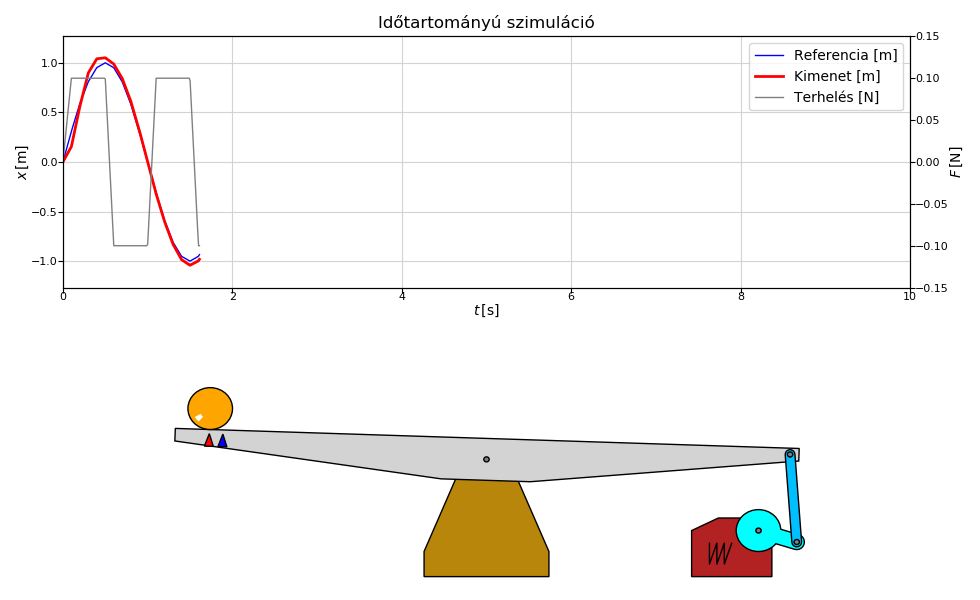

Output()

In [5]:
# Simulation

anim_fig = plt.figure()
anim_fig.set_size_inches((9.8, 6))
anim_fig.set_tight_layout(True)

anim_ax1 = anim_fig.add_subplot(211)
anim_ax2 = anim_ax1.twinx()

frame_count=1000

l1 = anim_ax1.plot([], [], lw=1, color='blue')
l2 = anim_ax1.plot([], [], lw=2, color='red')
l3 = anim_ax2.plot([], [], lw=1, color='grey')

line1 = l1[0]
line2 = l2[0]
line3 = l3[0]

anim_ax1.legend(l1+l2+l3, ['Referencia [m]', 'Kimenet [m]', 'Terhelés [N]'], loc=1)

anim_ax1.set_title('Időtartományú szimuláció', fontsize=12)
anim_ax1.set_xlabel(r'$t\/$[s]', labelpad=0, fontsize=10)
anim_ax1.set_ylabel(r'$x\/$[m]', labelpad=0, fontsize=10)
anim_ax1.tick_params(axis='both', which='both', pad=0, labelsize=8)
anim_ax2.set_ylabel(r'$F\/$[N]', labelpad=0, fontsize=10)
anim_ax2.tick_params(axis='both', which='both', pad=0, labelsize=8)

anim_ax1.grid(which='both', axis='both', color='lightgray')

T_plot = []
X_plot = []
D_plot = []
R_plot = []
P_plot = []

# Scene data

scene_ax = anim_fig.add_subplot(212)
scene_ax.set_xlim((-4.75, 4.75))
scene_ax.set_ylim((-1.5, 1.5))
scene_ax.axis('off')

rotation_transform = transforms.Affine2D()

scene_ax.add_patch(patches.Polygon(np.stack(([-3.5, -3.5, -0.5, 0.5, 3.5, 3.5, -3.5],
                                   [0.25, 0.1, -0.25, -0.25, 0.1, 0.25, 0.25])).T,
                                   fill = True, lw=1, ec='black', fc='lightgray', zorder=5,
                                   transform=rotation_transform + scene_ax.transData))
scene_ax.add_patch(patches.Polygon(np.stack(([-0.7, -0.7, 0.7, 0.7, 0.25, -0.25, -0.7],
                                   [-1.1, -1.4, -1.4, -1.1, 0, 0, -1.1])).T,
                                   fill = True, lw=1, ec='black', fc='darkgoldenrod', zorder=0))
scene_ax.add_patch(patches.Circle((0, 0), fill=True, radius=0.03, ec='black', fc='gray', lw=1, zorder=20))

ball = patches.Circle((0, 0.5), fill=True, radius=0.25, ec='black', fc='orange', lw=1,
                      zorder=5, transform=rotation_transform + scene_ax.transData)
gleam = patches.Wedge((0, 0.5), 0.2, fill=True, width=0.075, theta1=215, theta2=235, lw=0,
                      ec='white', fc='white', zorder=10, transform=rotation_transform + scene_ax.transData)

scene_ax.add_patch(ball)
scene_ax.add_patch(gleam)

center_drive_belt, = scene_ax.plot([-0.42, -0.15, 0.15, 0.42], [-0.8, 0.05, 0.05, -0.8], color='black', lw=3, zorder=10)

center_drive_1 = patches.Circle((0, 0), fill=True, radius=0.18, ec='black', fc='lawngreen', lw=1, zorder=15)
center_drive_2 = patches.Circle((0, -0.85), fill=True, radius=0.45, ec='black', fc='lawngreen', lw=1, zorder=15)
center_drive_shaft = patches.Circle((0, -0.85), fill=True, radius=0.03, ec='black', fc='gray', lw=1, zorder=25)
center_drive_mark_1 = patches.Wedge((0, -0.85), 0.40, theta1=260, theta2=280, width=0.32,
                                    fill=True, ec='black', fc='white', lw=1, zorder=20)
center_drive_mark_2 = patches.Wedge((0, -0.85), 0.40, theta1=80, theta2=100, width=0.32,
                                    fill=True, ec='black', fc='white', lw=1, zorder=20)

scene_ax.add_patch(center_drive_1)
scene_ax.add_patch(center_drive_2)
scene_ax.add_patch(center_drive_shaft)
scene_ax.add_patch(center_drive_mark_1)
scene_ax.add_patch(center_drive_mark_2)

wheel_transform = transforms.Affine2D()

drive_rod_outline, = scene_ax.plot([3.5, 3.4], [-0.85, 0.175], color='black', solid_capstyle='round', lw=8, zorder=15,
                                   visible=False)
drive_rod, = scene_ax.plot([3.5, 3.4], [-0.85, 0.175], color='deepskyblue', solid_capstyle='round', lw=6, zorder=20,
                           visible=False)
drive_wheel_rod_outline, = scene_ax.plot([3.05, 3.5], [-0.85, -0.85], color='black', solid_capstyle='round', lw=12, zorder=0,
                                         visible=False)
drive_wheel_rod, = scene_ax.plot([3.05, 3.5], [-0.85, -0.85], color='cyan', solid_capstyle='round', lw=10, zorder=10,
                                 visible=False)
drive_motor_grate, = scene_ax.plot([2.5, 2.5, 2.5833, 2.5833, 2.6666, 2.6666, 2.75],
                                   [-1, -1.25, -1, -1.25, -1, -1.25, -1],
                                   color='black', solid_capstyle='round', lw=1, zorder=5, visible=False)

drive_rod_p1 = patches.Circle((3.4, 0.175), fill=True, radius=0.03, ec='black', fc='gray', lw=1, zorder=25,
                              transform=rotation_transform + scene_ax.transData, visible=False)
drive_rod_p2 = patches.Circle((3.5, -0.85), fill=True, radius=0.03, ec='black', fc='gray', lw=1, zorder=25,
                              transform=wheel_transform + scene_ax.transData, visible=False)
drive_wheel = patches.Circle((3.05, -0.85), fill=True, radius=0.25, ec='black', fc='cyan', lw=1, zorder=5, visible=False)
drive_wheel_p = patches.Circle((3.05, -0.85), fill=True, radius=0.03, ec='black', fc='gray', lw=1, zorder=25, visible=False)
drive_motor = patches.Polygon(np.stack(([2.3, 3.2, 3.2, 2.6, 2.3, 2.3],
                              [-1.4, -1.4, -0.7, -0.7, -0.85, -1.4])).T,
                               fill = True, lw=1, ec='black', fc='firebrick', zorder=0, visible=False)

scene_ax.add_patch(drive_rod_p1)
scene_ax.add_patch(drive_rod_p2)
scene_ax.add_patch(drive_wheel)
scene_ax.add_patch(drive_wheel_p)
scene_ax.add_patch(drive_motor)

x_arrow = scene_ax.arrow(0, 0.05, 0, 0.15, ec='black', fc='blue', head_width=0.1,
                         length_includes_head=True, lw=1, fill=True, zorder=10,
                         transform=rotation_transform + scene_ax.transData)
r_arrow = scene_ax.arrow(0, 0.05, 0, 0.15, ec='black', fc='red', head_width=0.1,
                         length_includes_head=True, lw=1, fill=True, zorder=10,
                         transform=rotation_transform + scene_ax.transData)
base_arrow = x_arrow.xy


rot_pos = []
ball_pos = []
ref_pos = []
ball_rot = []
sys_type = 0

#Simulation function

def simulation(Kp, Ti, Td, Fd, Ti0, Td0, m, r, d, L, type_select, T, dt, X, Xf, Xa, Xo, F, Ff, Fa, Fo):
    
    # Controller
    P = Kp            # Proportional term
    I = Kp / Ti       # Integral term
    D = Kp * Td       # Derivative term
    Td_f = Td / Fd    # Derivative term filter
    
    W_PID = c.parallel(c.tf([P], [1]),
                       c.tf([I * Ti0], [1 * Ti0, 1 * (not Ti0)]),
                       c.tf([D * Td0, 0], [Td_f * Td0, 1]))  # PID controller
    
    # System
    
    J=2/5*m*r*r
    if type_select:
        W_sys = c.tf([m*g*d], [L*(J/(r*r)+m), 0, 0])
    else:
        W_sys = c.tf([m*g], [J/(r*r)+m, 0, 0])
    
    # Model
    W_open = c.series(W_PID, W_sys)         # Open loop 
    W_closed = c.feedback(W_open, 1, -1)    # Closed loop with negative feedback
    
    if type_select:   # Disturbance transfer
        W_s1 = c.tf([m*g*d], [L])
    else:
        W_s1 = c.tf([m*g], [1])
        
    W_s2 = c.tf([1], [J/r/r+m, 0, 0])
    W_load = c.feedback(W_s2, c.series(W_PID, W_s1), -1)
    
    W_cont_sys = c.feedback(W_PID, W_sys, -1)    # Control signal (angle) system component
    W_cont_load = c.feedback(c.series(W_s2, c.negate(W_PID)), W_s1, 1)     # Control signal (angle) load component         
    
    # Reference and disturbance signals

    T_sim = np.arange(0, T, dt, dtype=np.float64)
    
    if X == 0:     # Constant reference
        X_sim = np.full_like(T_sim, Xa * Xo)
    elif X == 1:   # Sine wave reference
        X_sim = (np.sin(2 * np.pi * Xf * T_sim) + Xo) * Xa
    elif X == 2:   # Square wave reference
        X_sim = (np.sign(np.sin(2 * np.pi * Xf * T_sim)) + Xo) * Xa
        
    if F == 0:     # Constant load
        F_sim = np.full_like(T_sim, Fa * Fo)
    elif F == 1:   # Sine wave load
        F_sim = (np.sin(2 * np.pi * Ff * T_sim) + Fo) * Fa
    elif F == 2:   # Square wave load
        F_sim = (np.sign(np.sin(2 * np.pi * Ff * T_sim)) + Fo) * Fa
    elif F == 3:   # Noise form load
        F_sim = np.interp(T_sim, np.linspace(0, T, int(T * Ff) + 2),
                          np.random.normal(loc=(Fo * Fa), scale=Fa, size=int(T * Ff) + 2))
    
    # System response
        
    Tx, youtx, xoutx = c.forced_response(W_closed, T_sim, X_sim)
    Tf, youtf, xoutf = c.forced_response(W_load, T_sim, F_sim)
    R_sim = np.nan_to_num(youtx + youtf)
                    
    Tcx, youtcx, xoutcx = c.forced_response(W_cont_sys, T_sim, X_sim)
    Tcf, youtcf, xoutcf = c.forced_response(W_cont_load, T_sim, F_sim)
    P_sim = np.nan_to_num(youtcx + youtcf)
    
    # Display
            
    XR_max = max(np.amax(np.absolute(np.concatenate((X_sim, R_sim)))), Xa)
    F_max = max(np.amax(np.absolute(F_sim)), Fa)
    P_max = np.amax(np.absolute(P_sim))
    
    anim_ax1.set_xlim((0, T))
    anim_ax1.set_ylim((-1.2 * XR_max, 1.2 * XR_max))
    anim_ax2.set_ylim((-1.5 * F_max, 1.5 * F_max))
    
    global T_plot, X_plot, F_plot, R_plot, P_plot, rot_pos, ball_pos, ref_pos, ball_rot, sys_type
    
    T_plot = np.linspace(0, T, frame_count, dtype=np.float32)
    X_plot = np.interp(T_plot, T_sim, X_sim)
    F_plot = np.interp(T_plot, T_sim, F_sim)
    R_plot = np.interp(T_plot, T_sim, R_sim)
    P_plot = np.interp(T_plot, T_sim, P_sim)
                    
    rot_pos = P_plot / P_max * -10   # The constant sets the apparent maximal tilt of the animation in degrees
    ball_pos = R_plot / XR_max * 3.4
    ref_pos = X_plot / XR_max * 3.4
    ball_rot = ball_pos / np.pi * -360
    sys_type = type_select
    

def anim_init():
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    
    ball.set_center((0, 0.5))
    gleam.set_center((0, 0.5))
    gleam.set_theta1(215)
    gleam.set_theta2(235)
    
    center_drive_mark_1.set_theta1(260)
    center_drive_mark_1.set_theta2(280)
    center_drive_mark_2.set_theta1(80)
    center_drive_mark_2.set_theta2(100)
    
    drive_rod_outline.set_data([3.5, 3.4], [-0.85, 0.175])
    drive_rod.set_data([3.5, 3.4], [-0.85, 0.175])
    drive_wheel_rod_outline.set_data([3.05, 3.5], [-0.85, -0.85])
    drive_wheel_rod.set_data([3.05, 3.5], [-0.85, -0.85])
    
    x_arrow.set_xy(base_arrow)
    r_arrow.set_xy(base_arrow)
    
    rotation_transform.clear()
    wheel_transform.clear()
    
    if sys_type:
        center_drive_1.set_visible(False)
        center_drive_2.set_visible(False)
        center_drive_shaft.set_visible(False)
        center_drive_belt.set_visible(False)
        center_drive_mark_1.set_visible(False)
        center_drive_mark_2.set_visible(False)
        
        drive_rod.set_visible(True)
        drive_rod_outline.set_visible(True)
        drive_wheel_rod.set_visible(True)
        drive_wheel_rod_outline.set_visible(True)
        drive_wheel.set_visible(True)
        drive_motor.set_visible(True)
        drive_rod_p1.set_visible(True)
        drive_rod_p2.set_visible(True)
        drive_wheel_p.set_visible(True)
        drive_motor_grate.set_visible(True)
        
    else:
        center_drive_1.set_visible(True)
        center_drive_2.set_visible(True)
        center_drive_shaft.set_visible(True)
        center_drive_belt.set_visible(True)
        center_drive_mark_1.set_visible(True)
        center_drive_mark_2.set_visible(True)
        
        drive_rod.set_visible(False)
        drive_rod_outline.set_visible(False)
        drive_wheel_rod.set_visible(False)
        drive_wheel_rod_outline.set_visible(False)
        drive_wheel.set_visible(False)
        drive_motor.set_visible(False)
        drive_rod_p1.set_visible(False)
        drive_rod_p2.set_visible(False)
        drive_wheel_p.set_visible(False)
        drive_motor_grate.set_visible(False)
    
    return (line1, line2, line3, ball, gleam, x_arrow, r_arrow, center_drive_1, center_drive_2,
            center_drive_shaft, center_drive_belt, center_drive_mark_1, center_drive_mark_2,
            drive_rod_outline, drive_rod, drive_wheel_rod_outline, drive_wheel_rod, drive_wheel, drive_motor,
            drive_rod_p1, drive_rod_p2, drive_wheel_p, drive_motor_grate,)

def animate(i):
    line1.set_data(T_plot[0:i], X_plot[0:i])
    line2.set_data(T_plot[0:i], R_plot[0:i])
    line3.set_data(T_plot[0:i], F_plot[0:i])
    
    ball.set_center((ball_pos[i], 0.5))
    gleam.set_center((ball_pos[i], 0.5))
    gleam.set_theta1(215 + ball_rot[i])
    gleam.set_theta2(235 + ball_rot[i])
    
    if sys_type:
        center_drive_1.set_visible(False)
        center_drive_2.set_visible(False)
        center_drive_shaft.set_visible(False)
        center_drive_belt.set_visible(False)
        center_drive_mark_1.set_visible(False)
        center_drive_mark_2.set_visible(False)
        
        drive_rod.set_visible(True)
        drive_rod_outline.set_visible(True)
        drive_wheel_rod.set_visible(True)
        drive_wheel_rod_outline.set_visible(True)
        drive_wheel.set_visible(True)
        drive_motor.set_visible(True)
        drive_rod_p1.set_visible(True)
        drive_rod_p2.set_visible(True)
        drive_wheel_p.set_visible(True)
        drive_motor_grate.set_visible(True)
        
    else:
        center_drive_1.set_visible(True)
        center_drive_2.set_visible(True)
        center_drive_shaft.set_visible(True)
        center_drive_belt.set_visible(True)
        center_drive_mark_1.set_visible(True)
        center_drive_mark_2.set_visible(True)
        
        drive_rod.set_visible(False)
        drive_rod_outline.set_visible(False)
        drive_wheel_rod.set_visible(False)
        drive_wheel_rod_outline.set_visible(False)
        drive_wheel.set_visible(False)
        drive_motor.set_visible(False)
        drive_rod_p1.set_visible(False)
        drive_rod_p2.set_visible(False)
        drive_wheel_p.set_visible(False)
        drive_motor_grate.set_visible(False)
        
    
    center_drive_mark_1.set_theta1(260 + rot_pos[i] / 2.5)
    center_drive_mark_1.set_theta2(280 + rot_pos[i] / 2.5)
    center_drive_mark_2.set_theta1(80 + rot_pos[i] / 2.5)
    center_drive_mark_2.set_theta2(100 + rot_pos[i] / 2.5)
    
    x_arrow.set_xy(base_arrow + [ref_pos[i], 0])
    r_arrow.set_xy(base_arrow + [ball_pos[i], 0])
    
    rotation_transform.clear().rotate_deg_around(0, 0, rot_pos[i])
    wheel_transform.clear().rotate_deg_around(3.05, -0.85, rot_pos[i] * 9)
    
    drive_rod_outline.set_data(np.stack((wheel_transform.transform_point([3.5, -0.85]),
                               rotation_transform.transform_point([3.4, 0.175]))).T)
    drive_rod.set_data(np.stack((wheel_transform.transform_point([3.5, -0.85]),
                                 rotation_transform.transform_point([3.4, 0.175]))).T)
    drive_wheel_rod_outline.set_data(np.stack(([3.05, -0.85], wheel_transform.transform_point([3.5, -0.85]))).T)
    drive_wheel_rod.set_data(np.stack(([3.05, -0.85], wheel_transform.transform_point([3.5, -0.85]))).T)
    
    return (line1, line2, line3, ball, gleam, x_arrow, r_arrow, center_drive_1, center_drive_2,
            center_drive_shaft, center_drive_belt, center_drive_mark_1, center_drive_mark_2,
            drive_rod_outline, drive_rod, drive_wheel_rod_outline, drive_wheel_rod, drive_wheel, drive_motor,
            drive_rod_p1, drive_rod_p2, drive_wheel_p, drive_motor_grate,)

anim = animation.FuncAnimation(anim_fig, animate, init_func=anim_init,
                               frames=frame_count, interval=10, blit=True,
                               repeat=True)

# Controllers

T_slider = w.FloatLogSlider(value=10, base=10, min=-0.7, max=1, step=0.01,
                            description='Hossz [s]:', continuous_update=False,
                            orientation='vertical', layout=w.Layout(width='auto', height='auto', flex='1 1 auto'))

dt_slider = w.FloatLogSlider(value=0.1, base=10, min=-3, max=-1, step=0.01,
                             description='Lépésköz [s]:', continuous_update=False,
                             orientation='vertical', layout=w.Layout(width='auto', height='auto', flex='1 1 auto'))
       
X_type = w.Dropdown(options=[('Állandó', 0), ('Szinusz', 1), ('Négyszög', 2)], value=1,
                     description='Referencia: ', continuous_update=False, layout=w.Layout(width='auto', flex='3 3 auto'))    
Xf_slider = w.FloatLogSlider(value=0.5, base=10, min=-2, max=2, step=0.01,
                             description='Frekvencia [Hz]:', continuous_update=False,
                             orientation='vertical', layout=w.Layout(width='auto', height='auto', flex='1 1 auto'))
Xa_slider = w.FloatLogSlider(value=1, base=10, min=-2, max=2, step=0.01,
                             description='Amplitúdó [m]:', continuous_update=False,
                             orientation='vertical', layout=w.Layout(width='auto', height='auto', flex='1 1 auto'))
Xo_slider = w.FloatSlider(value=0, min=-10, max=10, description='Offszet/Ampl:', continuous_update=False,
                              orientation='vertical', layout=w.Layout(width='auto', height='auto', flex='1 1 auto'))    
    
F_type = w.Dropdown(options=[('Állandó', 0), ('Szinusz', 1), ('Négyszög', 2), ('Zaj', 3)], value=2,
                     description='Terhelés: ', continuous_update=False, layout=w.Layout(width='auto', flex='3 3 auto'))    
Ff_slider = w.FloatLogSlider(value=1, base=10, min=-2, max=2, step=0.01,
                             description='Frekvencia [Hz]:', continuous_update=False,
                             orientation='vertical', layout=w.Layout(width='auto', height='auto', flex='1 1 auto'))
Fa_slider = w.FloatLogSlider(value=0.1, base=10, min=-2, max=2, step=0.01,
                             description='Amplitúdó [N]:', continuous_update=False,
                             orientation='vertical', layout=w.Layout(width='auto', height='auto', flex='1 1 auto'))
Fo_slider = w.FloatSlider(value=0, min=-10, max=10, description='Offszet/Ampl:', continuous_update=False,
                              orientation='vertical', layout=w.Layout(width='auto', height='auto', flex='1 1 auto'))

input_data = w.interactive_output(simulation, {'Kp': Kp_slider, 'Ti': Ti_slider, 'Td': Td_slider,
                                               'Fd': Fd_slider, 'Ti0' : Ti_button, 'Td0': Td_button,
                                               'm':m_slider, 'r':r_slider, 'd':d_slider, 'L':L_slider,
                                               'type_select':typeSelect,
                                               'T': T_slider, 'dt': dt_slider,
                                               'X': X_type, 'Xf': Xf_slider, 'Xa': Xa_slider, 'Xo': Xo_slider,
                                               'F': F_type, 'Ff': Ff_slider, 'Fa': Fa_slider, 'Fo': Fo_slider})

display(w.HBox([w.HBox([T_slider, dt_slider], layout=w.Layout(width='25%')),
                w.Box([], layout=w.Layout(width='5%')),
                w.VBox([X_type, w.HBox([Xf_slider, Xa_slider, Xo_slider])], layout=w.Layout(width='30%')),
                w.Box([], layout=w.Layout(width='5%')),
                w.VBox([F_type, w.HBox([Ff_slider, Fa_slider, Fo_slider])], layout=w.Layout(width='30%'))],
                layout=w.Layout(width='100%', justify_content='center')), input_data)

A hossz paraméter a szimulált időtartamot szabályozza és nincsen hatással a szimuláció futási időtartamára. Ezzel szemben a lépésköz a mintavételezés sűrűségét befolyásolja, finomíthatja az eredmények megjelenését, de jelentősen megnöveli a szükséges számítási teljesítményt.